In [51]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(0, '../snow_terrain_tiles/')
from dem_utils import recursive_rastersstats_to_dict
from mpl_toolkits.axes_grid1 import make_axes_locatable
from directional_terrain_analysis import make_hillshade
import os
import matplotlib.gridspec as gridspec

In [52]:
d = recursive_rastersstats_to_dict('../subsets/', '*_snow_depth_2*')
d.keys()

dict_keys(['../subsets/clpx_swale/raster/snow_depth/clpx_swale_snow_depth_2018.tif', '../subsets/clpx_swale/raster/snow_depth/clpx_swale_snow_depth_2015.tif', '../subsets/clpx_swale/raster/snow_depth/clpx_swale_snow_depth_2013.tif', '../subsets/clpx_swale/raster/snow_depth/clpx_swale_snow_depth_2012.tif', '../subsets/clpx_swale/raster/snow_depth/clpx_swale_snow_depth_2017.tif', '../subsets/clpx_swale/raster/snow_depth/clpx_swale_snow_depth_2016.tif', '../subsets/clpx_watertracks_creek/raster/snow_depth/clpx_watertracks_creek_snow_depth_2017.tif', '../subsets/clpx_watertracks_creek/raster/snow_depth/clpx_watertracks_creek_snow_depth_2018.tif', '../subsets/clpx_watertracks_creek/raster/snow_depth/clpx_watertracks_creek_snow_depth_2015.tif', '../subsets/clpx_watertracks_creek/raster/snow_depth/clpx_watertracks_creek_snow_depth_2016.tif', '../subsets/clpx_watertracks_creek/raster/snow_depth/clpx_watertracks_creek_snow_depth_2013.tif', '../subsets/clpx_watertracks_creek/raster/snow_depth/cl

In [53]:
arrs = []
titles = []
for k in d.keys():
    arrs.append(d[k]['arr'])
    titles.append(k)
    
titles

['../subsets/clpx_swale/raster/snow_depth/clpx_swale_snow_depth_2018.tif',
 '../subsets/clpx_swale/raster/snow_depth/clpx_swale_snow_depth_2015.tif',
 '../subsets/clpx_swale/raster/snow_depth/clpx_swale_snow_depth_2013.tif',
 '../subsets/clpx_swale/raster/snow_depth/clpx_swale_snow_depth_2012.tif',
 '../subsets/clpx_swale/raster/snow_depth/clpx_swale_snow_depth_2017.tif',
 '../subsets/clpx_swale/raster/snow_depth/clpx_swale_snow_depth_2016.tif',
 '../subsets/clpx_watertracks_creek/raster/snow_depth/clpx_watertracks_creek_snow_depth_2017.tif',
 '../subsets/clpx_watertracks_creek/raster/snow_depth/clpx_watertracks_creek_snow_depth_2018.tif',
 '../subsets/clpx_watertracks_creek/raster/snow_depth/clpx_watertracks_creek_snow_depth_2015.tif',
 '../subsets/clpx_watertracks_creek/raster/snow_depth/clpx_watertracks_creek_snow_depth_2016.tif',
 '../subsets/clpx_watertracks_creek/raster/snow_depth/clpx_watertracks_creek_snow_depth_2013.tif',
 '../subsets/clpx_watertracks_creek/raster/snow_depth/c

In [72]:
def find_drift_threshold(snow):

    # Compute some basic stats
    mean_depth = np.nanmean(snow)
    std_depth = np.nanstd(snow)
    cv_depth = std_depth / mean_depth

    # Thresholds to test (percentages of the mean depth)
    # Expect the threshold to be above average depth
    thresholds = np.round(np.arange(0.8, 2.3, 0.1) * mean_depth, 2)

    # Computing total area / volume of all snow pixels
    pxl_sz = 1
    total_area = (~np.isnan(snow)).sum() * pxl_sz
    total_volume = np.nansum((~np.isnan(snow)) * snow * pxl_sz)
    
    # Compute depth thresholds
    d = dict()
    for i in thresholds:

        k = str(i) + ' m'
        #print('testing threshold of ' + k + '...')

        drift_mask = (snow >= i)
        depth_drift_masked = drift_mask * snow
        depth_drift_masked[depth_drift_masked == 0] = np.nan
        
        not_drift_mask = (snow < i)
        depth_not_drift_masked = not_drift_mask * snow
        depth_not_drift_masked[depth_not_drift_masked == 0] = np.nan

        d[k] = {}
        d[k]['drift_area'] = int(np.nansum(drift_mask))
        d[k]['not_drift_area'] = int(np.nansum(not_drift_mask))
        d[k]['drift_volume'] = int(np.nansum(drift_mask * snow * pxl_sz))
        d[k]['not_drift_volume'] = int(np.nansum(not_drift_mask * snow * pxl_sz))

        
    # Move to dict to df
    df = pd.DataFrame.from_dict(d).T
    df['Drift Threshold (pct. of mean depth)'] = np.arange(0.8, 2.3, 0.1) * 100
    df['Drift Area pct.'] = df.drift_area / total_area * 100
    df['Not Drift Area pct.'] = df.not_drift_area / total_area * 100
    df['Drift Volume pct.'] = df.drift_volume / total_volume * 100
    df['Not Drift Volume pct.'] = df.not_drift_volume / total_volume * 100
    
    # Find the inflection Threshold
    df['Drift Volume-Area Difference (pct.)'] = df['Drift Volume pct.'] - df['Drift Area pct.']
    df['Drift Volume-Area Difference Slope'] = np.gradient(df['Drift Volume-Area Difference (pct.)'])
    df.set_index(df['Drift Threshold (pct. of mean depth)'], inplace=True)
    inflection = df['Drift Volume-Area Difference Slope'].idxmin()
    df['Inflection Threshold'] = inflection
    
    depth_thresh = (inflection / 100.0) * mean_depth
    
    return df, inflection, depth_thresh

# df['Mean_Depth [m]'] = mean_depth
# df['SD Depth [m]'] = std_depth
# df['CV'] = cv_depth

# print(inflection)

# # Write this data out to a .csv file
# df.to_csv('results/drift_thresholds_' + mtn + study_area +'_' + year + '.csv')


In [73]:
for k in d.keys():
    d[k]['drift_def'], d[k]['thresh'], d[k]['depth_thresh'] = find_drift_threshold(d[k]['arr'])

In [74]:
import random
d4 = dict(random.sample(d.items(), 8))

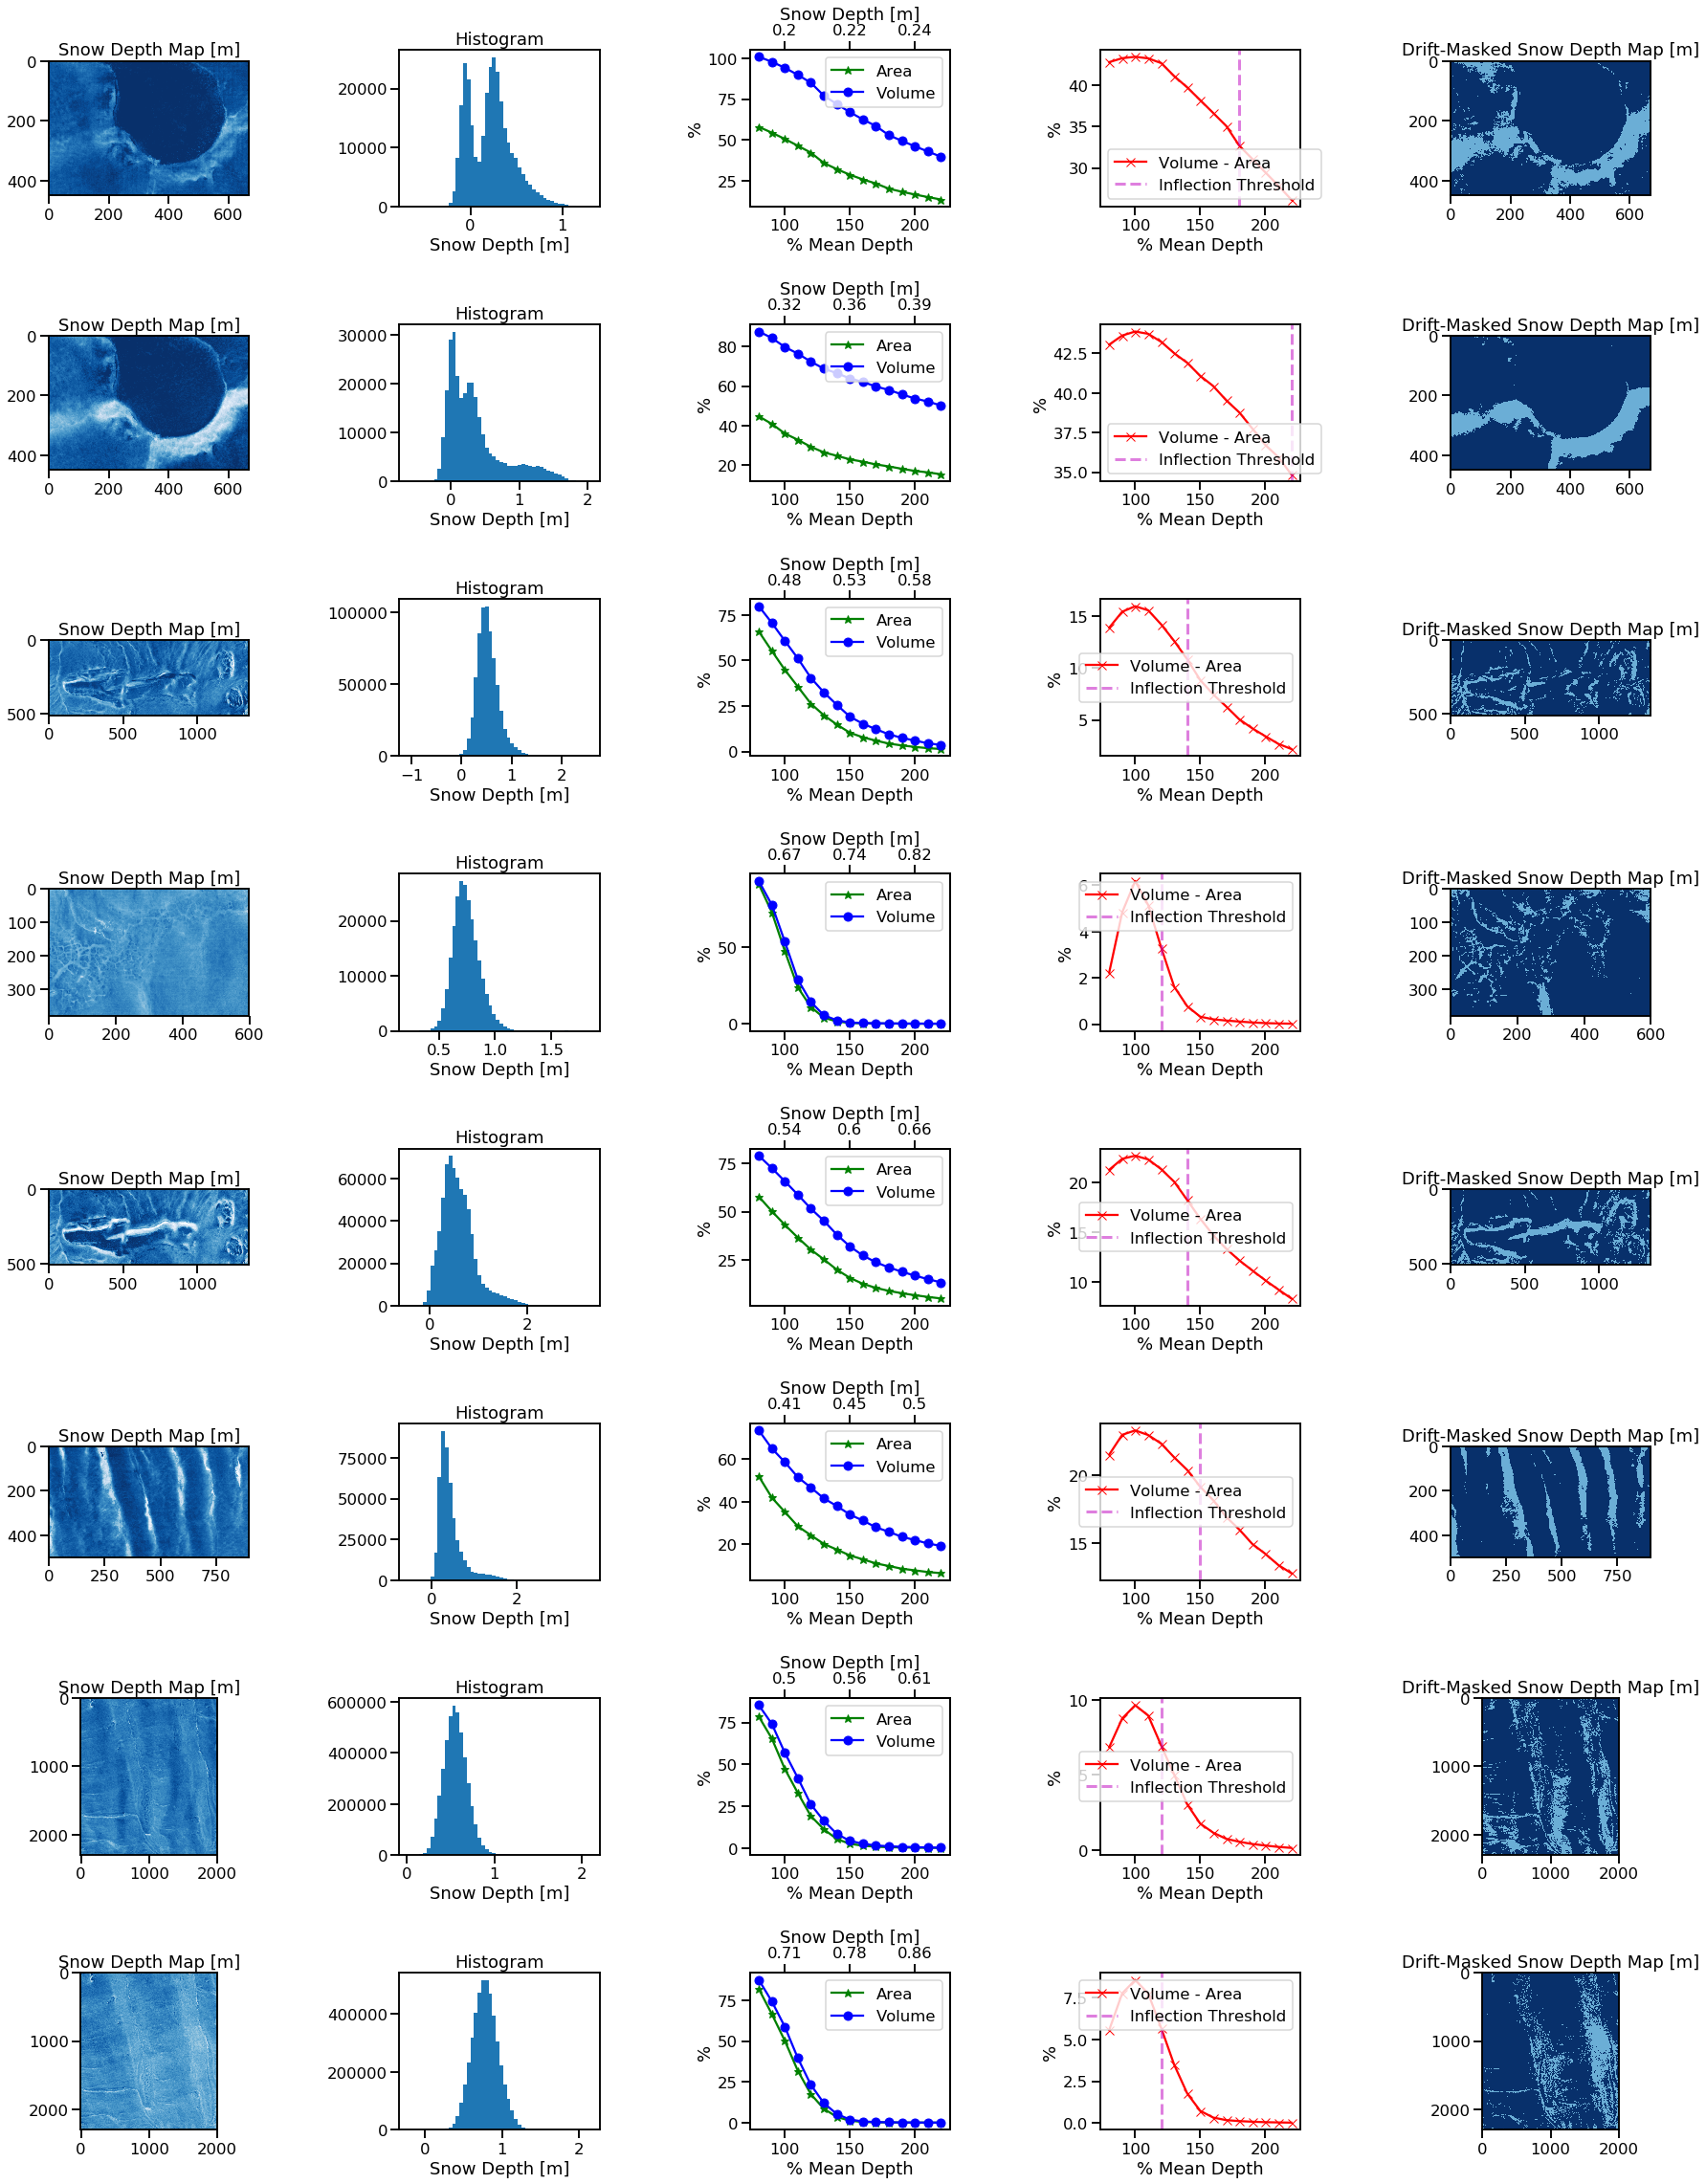

In [75]:
sns.set_context('talk')

f, axes = plt.subplots(8, 5, figsize=(30,40))
f.subplots_adjust(hspace=0.75, wspace=0.75)

i = 0

for k in d4.keys():
    
    
    axes[i][0].imshow(d4[k]['arr'], vmin=0, vmax=2, cmap='Blues_r')
    axes[i][0].set_title('Snow Depth Map [m]')


    axes[i][1].hist(d4[k]['arr'].flatten(), bins=50, histtype='stepfilled')
    axes[i][1].set_title('Histogram')
    axes[i][1].set_xlabel('Snow Depth [m]')


    axes[i][2].plot(d4[k]['drift_def']['Drift Threshold (pct. of mean depth)'],
                    d4[k]['drift_def']['Drift Area pct.'],
                    '-g*', label = 'Area')
    axes[i][2].plot(d4[k]['drift_def']['Drift Threshold (pct. of mean depth)'],
                    d4[k]['drift_def']['Drift Volume pct.'],
                    '-bo', label = 'Volume')
    axes[i][2].set_ylabel('%')
    axes[i][2].set_xlabel('% Mean Depth')
    axes[i][2].legend()


    ax2 = axes[i][2].twiny()
    ax1Xs = axes[i][2].get_xticks()
    ax2Xs = []
    for t in d4[k]['drift_def']['Drift Threshold (pct. of mean depth)'].values:
        ax2Xs.append(round(d4[k]['arr'].mean() * (t/100), 2))
    ax2.set_xticks(ax1Xs)
    ax2.set_xbound(axes[i][2].get_xbound())
    ax2.set_xticklabels(ax2Xs)
    ax2.set_xlabel('Snow Depth [m]')


    axes[i][3].plot(d4[k]['drift_def']['Drift Threshold (pct. of mean depth)'],
                    d4[k]['drift_def']['Drift Volume-Area Difference (pct.)'],
                    '-rx', label = 'Volume - Area')
    axes[i][3].axvline(x=d4[k]['thresh'],
                       color='m', alpha=0.5, lw=3, ls='--', label = 'Inflection Threshold')
    axes[i][3].set_xlabel('% Mean Depth')
    axes[i][3].set_ylabel('%')

    axes[i][3].legend()
    
    
    
    axes[i][4].imshow(d4[k]['arr'] > d4[k]['depth_thresh'], vmin=0, vmax=2, cmap='Blues_r')
    axes[i][4].set_title('Drift-Masked Snow Depth Map [m]')

    
    
    i += 1

In [62]:

d4

{'../subsets/hv_watertrack/raster/snow_depth/hv_watertrack_snow_depth_2012.tif': {'arr': array([[0.6053857 , 0.54950804, 0.47498414, ..., 0.42096803, 0.43799683,
          0.43607423],
         [0.63962644, 0.5829858 , 0.5272302 , ..., 0.39334962, 0.38538453,
          0.36255738],
         [0.66373533, 0.5671167 , 0.5080041 , ..., 0.39569947, 0.39856812,
          0.3778467 ],
         ...,
         [0.6438684 , 0.63306516, 0.5907983 , ..., 0.44760987, 0.5134668 ,
          0.500802  ],
         [0.6216821 , 0.6305322 , 0.6390771 , ..., 0.44294068, 0.46238038,
          0.47879884],
         [0.5956506 , 0.6110315 , 0.64347166, ..., 0.46805665, 0.43955323,
          0.4572229 ]], dtype=float32),
  'mu': 0.45278993,
  'sigma': 0.27130017,
  'kurt': 5.629711278827248,
  'skew': 2.0302929878234863,
  'CV': 0.59917444,
  'profile': {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 900, 'height': 500, 'count': 1, 'crs': CRS.from_dict(init='epsg:32606'), 'transform': Affin

In [ ]:
sam